In [1]:
import os
os.chdir('/Users/ramupadhyay')
import torch
if torch.cuda.is_available():
    print("1")
else:
    print('0')
!ping -c 2 google.com

0
PING google.com (172.217.166.14): 56 data bytes
64 bytes from 172.217.166.14: icmp_seq=0 ttl=118 time=33.510 ms
64 bytes from 172.217.166.14: icmp_seq=1 ttl=118 time=39.392 ms

--- google.com ping statistics ---
2 packets transmitted, 2 packets received, 0.0% packet loss
round-trip min/avg/max/stddev = 33.510/36.451/39.392/2.941 ms


In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import ssl

BATCH_SIZE = 128
EPOCHS = 10
LEARNING_RATE = 0.001


class FeedForwardNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.dense_layers = nn.Sequential(
            nn.Linear(28 * 28, 256),
            nn.ReLU(),
            nn.Linear(256, 10)
        )
        self.softmax = nn.Softmax(dim=1)

    def forward(self, input_data):
        x = self.flatten(input_data)
        logits = self.dense_layers(x)
        predictions = self.softmax(logits)
        return predictions


def download_datasets():
    ssl._create_default_https_context = ssl._create_unverified_context
    train_data = datasets.MNIST(root='data', train=True, download=True, transform=ToTensor())
    validation_data = datasets.MNIST(root='data', train=False, download=True, transform=ToTensor())
    return train_data, validation_data


def data_loader(train_data, batch_size):
    train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    return train_dataloader


def train_one_epoch(model, data_loader, optimiser, loss_fn, device):
    for input, target in data_loader:
        input, target = input.to(device), target.to(device)
        prediction = model(input)
        loss = loss_fn(prediction, target)
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
    print(f"loss: {loss.item()}")


def train(model, data_loader, optimiser, loss_fn, device, epochs):
    for i in range(epochs):
        print(f'Epoch {i + 1}')
        train_one_epoch(model, data_loader, optimiser, loss_fn, device)
        print('---------------')
    print('Finished Training')


if __name__ == '__main__':
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using {device}")

    train_data, _ = download_datasets()
    train_dataloader = data_loader(train_data, BATCH_SIZE)

    feed_forward_net = FeedForwardNet().to(device)
    print(feed_forward_net)

    loss_fn = nn.CrossEntropyLoss()
    optimiser = torch.optim.Adam(feed_forward_net.parameters(), lr=LEARNING_RATE)

    train(feed_forward_net, train_dataloader, optimiser, loss_fn, device, EPOCHS)

    torch.save(feed_forward_net.state_dict(), "feedforwardnet.pth")
    print("Trained feed forward net saved at feedforwardnet.pth")


Using cpu


100.0%
100.0%
100.0%
100.0%


FeedForwardNet(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dense_layers): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=10, bias=True)
  )
  (softmax): Softmax(dim=1)
)
Epoch 1
loss: 1.5257679224014282
---------------
Epoch 2
loss: 1.5221853256225586
---------------
Epoch 3
loss: 1.4775762557983398
---------------
Epoch 4
loss: 1.5000969171524048
---------------
Epoch 5
loss: 1.5154496431350708
---------------
Epoch 6
loss: 1.525317668914795
---------------
Epoch 7
loss: 1.4637566804885864
---------------
Epoch 8
loss: 1.4823641777038574
---------------
Epoch 9
loss: 1.462740421295166
---------------
Epoch 10
loss: 1.4922784566879272
---------------
Finished Training
Trained feed forward net saved at feedforwardnet.pth


In [10]:
class_mapping=[str(i) for i in range(10)]

def predict(model,input,target,class_mapping):
    model.eval()
    with torch.no_grad():
        predictions=model(input)
        predicted_index=predictions[0].argmax(0)
        predicted=class_mapping[predicted_index]
        expected=class_mapping[target]
    return predicted,expected

if __name__=='__main__':
    _,validation_data=download_datasets()
    input,target=validation_data[0][0],validation_data[0][1]
    predicted,expected=predict(feed_forward_net,input,target,class_mapping)
    print(f'Predicted: "{predicted}", Expected: "{expected}"')
    

Predicted: "7", Expected: "7"


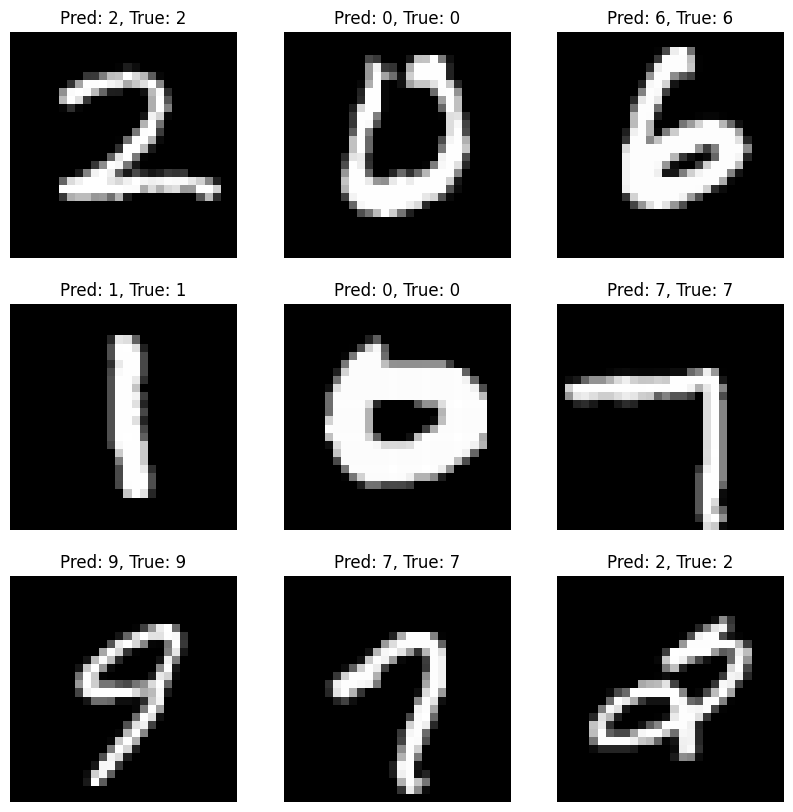

In [11]:
import matlplotlib.pyplot as plt
feed_forward_net.eval()

fig = plt.figure(figsize=(10, 10))
rows, cols = 3, 3
for i in range(1, rows*cols + 1):
    idx = torch.randint(0, len(validation_data), (1,)).item()
    img, label = validation_data[idx]
    with torch.no_grad():
        pred = feed_forward_net(img.unsqueeze(0))
        predicted = pred.argmax(1).item()
    fig.add_subplot(rows, cols, i)
    plt.title(f"Pred: {predicted}, True: {label}")
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")

plt.show()


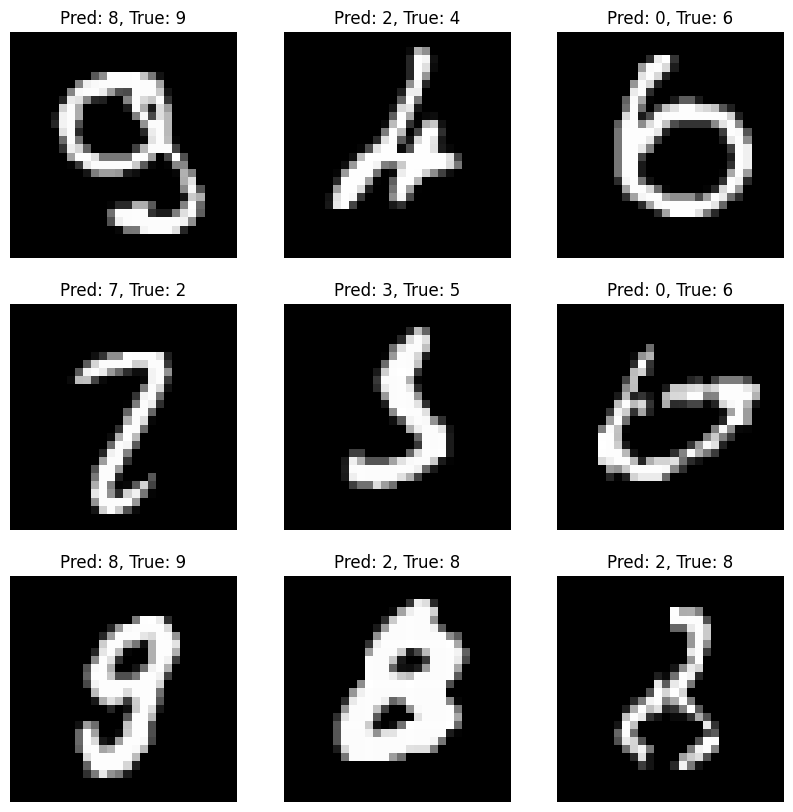

In [12]:
feed_forward_net.eval()
misclassified = []

for img, label in validation_data:
    with torch.no_grad():
        pred = feed_forward_net(img.unsqueeze(0))
        predicted = pred.argmax(1).item()
    if predicted != label:
        misclassified.append((img, label, predicted))
    if len(misclassified) == 9:
        break

fig = plt.figure(figsize=(10, 10))
for i, (img, label, predicted) in enumerate(misclassified):
    fig.add_subplot(3, 3, i+1)
    plt.title(f"Pred: {predicted}, True: {label}")
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()


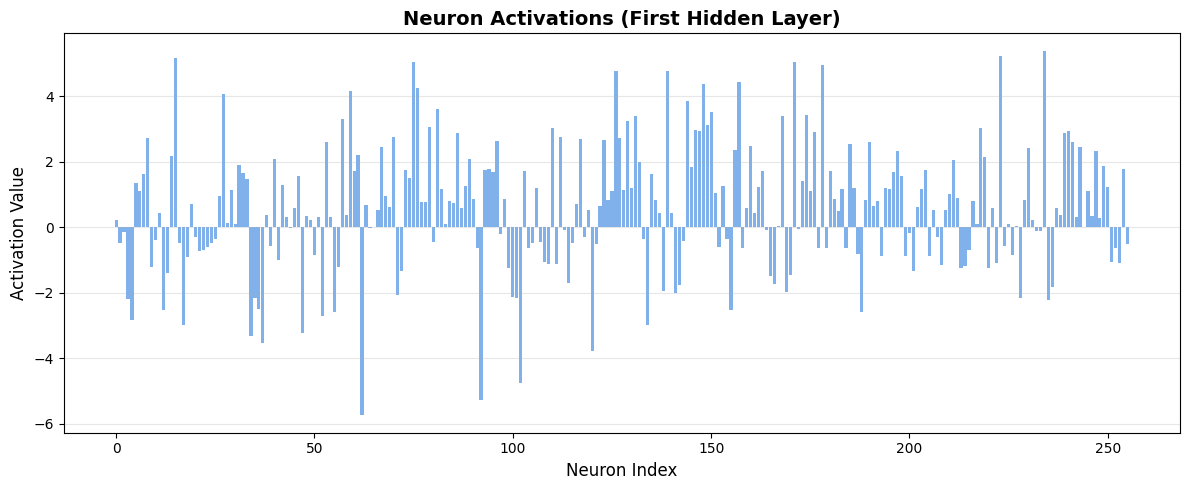

In [16]:
import numpy as np
plt.figure(figsize=(12, 5))
plt.bar(np.arange(len(act)), act, color="#4a90e2", alpha=0.7)
plt.title("Neuron Activations (First Hidden Layer)", fontsize=14, weight="bold")
plt.xlabel("Neuron Index", fontsize=12)
plt.ylabel("Activation Value", fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()
